In [1]:
# %%
from dataclasses import replace
import itertools
from typing import Sequence

from infrastructure.interrupt import InterruptHandler

from experiment import experiment_relu_kan, experiment_spec
from experiment.kan import conv_2d_relu_kan
from experiment.kan.conv_2d_spec import KanSpec

data_version = 'v2'
data_source = experiment_relu_kan.version_to_data_source[data_version]
print(
    data_version,
    'train:',
    data_source.get_fold_size('train'),
    'valid:',
    data_source.get_fold_size('test'),
)


def train_func(
    num_block_repeats: Sequence[int],
    block_num_layers: int,
    end_epoch: int | None = None,
) -> None:
    assert all(isinstance(ni, int) and ni > 0 for ni in num_block_repeats)

    num_block_types = len(num_block_repeats)
    assert num_block_types > 0
    assert all(repeats > 0 for repeats in num_block_repeats)

    downsample_first_block = False
    expand_first_block = True
    num_channels_base = 64

    args = replace(
        experiment_relu_kan.TrainArgs(
            data_version=data_version,
            augment=True,  # like in ResNet paper
            batch_len=32,  # 128 in ResNet paper
            end_epoch=end_epoch,
            lr=1e-4,  # 0.1 in ResNet paper
            weight_decay=1e-2,  # 0.0001 in ResNet paper
            weight_decay_splines=False,
            model_spec=experiment_spec.Conv2dModelSpecRepr(
                input_shape=data_source.input_shape,
                input_channels=data_source.num_channels,
                output_channels=data_source.num_classes,
                blocks_kernel=[(3, 3)] * sum(num_block_repeats),
                blocks_stride=list(
                    itertools.chain(
                        *(
                            (
                                [(1, 1)] * repeats
                                if i == 0 and not downsample_first_block
                                else [(2, 2)] + [(1, 1)] * (repeats - 1)
                            )
                            for i, repeats in enumerate(num_block_repeats)
                        )
                    )
                ),
                blocks_padding=[(1, 1)] * sum(num_block_repeats),
                blocks_channels=[
                    (
                        num_channels_base
                        * 2 ** (max(0, i - 1) if not expand_first_block else i)
                    )
                    for i, repeats in enumerate(num_block_repeats)
                    for _ in range(repeats)
                ],
                blocks_channels_interact=[True] * sum(num_block_repeats),
                blocks_num_layers=[block_num_layers] * sum(num_block_repeats),
                blocks_use_batch_norm=[True] * sum(num_block_repeats),
                kan_spec=KanSpec(g=5, k=3, center_zero=True, scale=0.375),
            ),
            model_cls=conv_2d_relu_kan.ResConv2dReLUKAN,
            # train_from_scratch=True,
        )
    )

    with InterruptHandler() as interrupt_handler:
        model = experiment_relu_kan.train(
            args, interrupt_handler=interrupt_handler, seed=42
        )
        del model

v2 train: 50000 valid: 10000


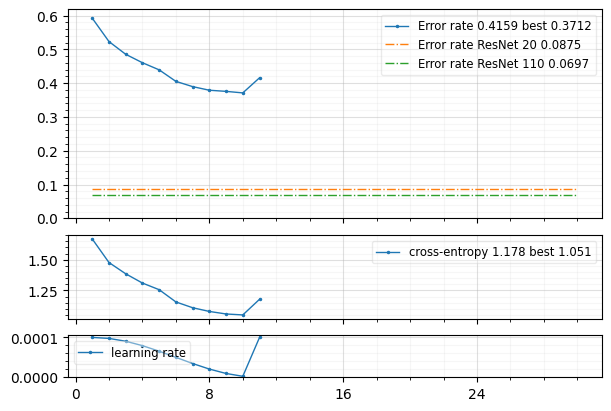

train epoch 11:   0%|          | 0/1563 [00:00<?, ?it/s]

In [3]:
# %%
train_func(
    (3, 1, 1, 1),
    block_num_layers=1,
    end_epoch=75,
)

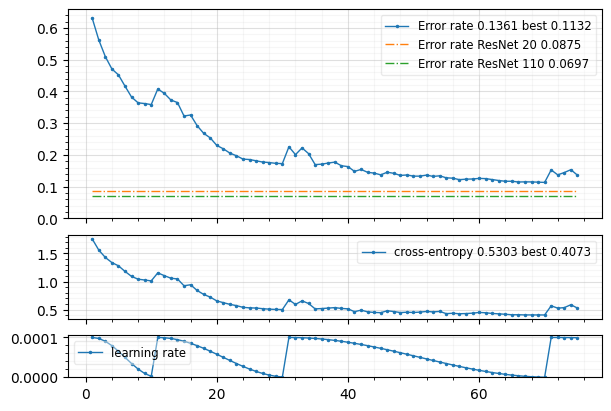

In [5]:
# %%
train_func(
    (2, 2, 2, 2),
    block_num_layers=1,
    end_epoch=75,
)